# Zadanie 5 — Asymilacja danych: ABC i 3D-Var (modele PDE i ODE)

Cel:
- Wygenerować „rzeczywiste” dane z modelu PDE (trajektoria TB(t) + szum pomiarowy).
- Przeprowadzić asymilację na modelach ODE i, opcjonalnie, PDE dwoma metodami: ABC i 3D-Var.
- Sprawdzić jakość predykcji w przód (poza oknem obserwacji) i w tył (przed oknem obserwacji).
- Raportować wyniki dla trzech budżetów obliczeniowych: mały, średni, duży.
Zapisy: wykresy → `figs/`, tabele/JSON → `out/`.

In [1]:
import os, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Path("figs").mkdir(exist_ok=True)
Path("out").mkdir(exist_ok=True)

# SciPy: integracja ODE i optymalizacja
try:
    from scipy.integrate import solve_ivp
    from scipy.optimize import minimize
    SCIPY_OK = True
except Exception as e:
    SCIPY_OK = False
    print("Uwaga: SciPy niedostępny -> 3D-Var/solve_ivp mogą nie działać:", e)

def savefig_f(fname, dpi=160):
    if not str(fname).startswith("figs/"):
        fname = f"figs/{fname}"
    plt.savefig(fname, dpi=dpi, bbox_inches="tight")
    print(f"[Zapisano wykres] {fname}")

def save_json(obj, path):
    if not str(path).startswith("out/"):
        path = f"out/{path}"
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)
    print(f"[Zapisano JSON] {path}")

In [2]:
from dataclasses import dataclass

@dataclass
class ODEParams:
    rho_S: float = 0.04
    rho_R: float = 0.03
    K: float = 1.0
    alpha_S: float = 0.8
    alpha_R: float = 0.12
    sigma: float = 0.05
    delta: float = 0.1
    gamma_S: float = 0.02
    gamma_R: float = 0.02
    lam: float = 0.2
    beta: float = 0.0
    mu_max: float = 0.05
    C50: float = 0.2
    m_hill: int = 3
    dose_type: str = "bolus_periodic"   # 'bolus_periodic' | 'infusion_const' | 'none'
    dose_A: float = 1.0
    dose_period: float = 5.0
    infusion_rate: float = 0.0

def mu_of_C(C, mu_max, C50, m):
    Cn = max(C, 0.0)
    ratio = (Cn / (C50 + 1e-12))**m
    return mu_max * (ratio / (1.0 + ratio))

def dosing_term_exact(t, dt, period, A):
    tau = 0.01 * period
    t0 = (t // period) * period
    start, end = t0, t0 + tau
    overlap = max(0.0, min(t+dt, end) - max(t, start))
    return (A / tau) * (overlap / max(dt, 1e-12))

def ode_rhs(t, y, p: ODEParams, dt_for_dose):
    S, R, I, C = y
    N = S + R
    dS = p.rho_S * S * (1 - N/p.K) - p.alpha_S*C*S - p.gamma_S*I*S
    dR = p.rho_R * R * (1 - N/p.K) - p.alpha_R*C*R - p.gamma_R*I*R
    mu = mu_of_C(C, p.mu_max, p.C50, p.m_hill)
    dS -= mu * S
    dR += mu * S
    dI = p.sigma * N - p.delta * I
    dC = - p.lam * C - p.beta * C * N
    if p.dose_type == "infusion_const":
        I_in = p.infusion_rate
    elif p.dose_type == "bolus_periodic":
        I_in = dosing_term_exact(t, dt_for_dose, p.dose_period, p.dose_A)
    else:
        I_in = 0.0
    dC += I_in
    return np.array([dS, dR, dI, dC], dtype=float)

def simulate_ode(p: ODEParams, y0, t_eval):
    dt = np.mean(np.diff(t_eval)) if len(t_eval) > 1 else 1e-2
    def fun(t, y): return ode_rhs(t, y, p, dt)
    sol = solve_ivp(fun, (t_eval[0], t_eval[-1]), y0, t_eval=t_eval, rtol=1e-7, atol=1e-9)
    if not sol.success:
        raise RuntimeError(sol.message)
    Y = sol.y.T
    S, R, I, C = Y[:,0], Y[:,1], Y[:,2], Y[:,3]
    TB = S + R
    return {"t": t_eval, "S": S, "R": R, "I": I, "C": C, "TB": TB}

## Dane „rzeczywiste” z PDE oraz wybór okna obserwacji
- Próbujemy załadować Twój moduł PDE (z Zadania 2).
- Jeśli jest dostępny, generujemy „true” TB(t) z PDE w horyzoncie `[0, T_end]`, a następnie tworzymy obserwacje z szumem Gaussa.
- Te same obserwacje wykorzystamy do asymilacji ODE (celowo) — ODE ma się dopasować do danych PDE.

[Zapisano trajektorię] out/explicit_Nx96_Ny96_traj.csv
[Zapisano metadane] out/explicit_Nx96_Ny96_info.json
[Zapisano macierz] out/explicit_Nx96_Ny96_S_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_R_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_I_final.npy
[Zapisano macierz] out/explicit_Nx96_Ny96_C_final.npy
[Zapisano wykres] figs/explicit_S_final.png
[Zapisano wykres] figs/explicit_R_final.png
[Zapisano wykres] figs/explicit_I_final.png
[Zapisano wykres] figs/explicit_C_final.png
[Zapisano trajektorię] out/semi_implicit_Nx96_Ny96_traj.csv
[Zapisano metadane] out/semi_implicit_Nx96_Ny96_info.json
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_S_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_R_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_I_final.npy
[Zapisano macierz] out/semi_implicit_Nx96_Ny96_C_final.npy
[Zapisano wykres] figs/semi_implicit_S_final.png
[Zapisano wykres] figs/semi_implicit_R_final.png
[Zapisano wykres] figs/semi_implicit_I_final.png

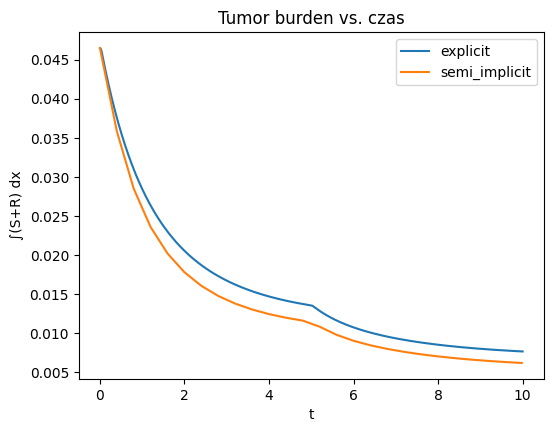

[explicit] N=64  dt=9.070e-04  time=0.73s  TB=0.01344
[semi_implicit] N=64  dt=2.000e-02  time=1.24s  TB=0.01149
[explicit] N=96  dt=3.989e-04  time=3.41s  TB=0.01357
[semi_implicit] N=96  dt=2.000e-02  time=3.23s  TB=0.01149
[explicit] N=128  dt=2.232e-04  time=8.95s  TB=0.01358
[semi_implicit] N=128  dt=2.000e-02  time=6.76s  TB=0.01149
[Zapisano] out/benchmark_resolutions.csv
[Zapisano wykres] figs/benchmark_time_vs_N.png


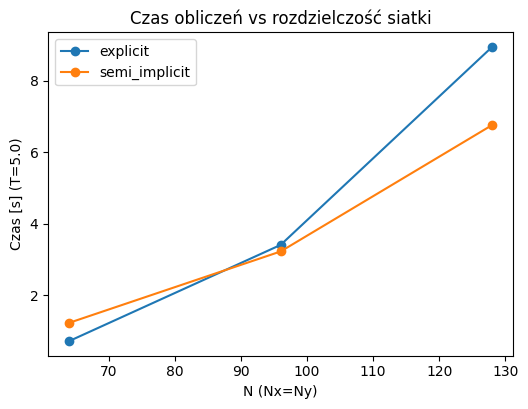

[explicit] dt=1.008e-03 steps=4962 time=0.67s
[explicit] dt=6.719e-04 steps=7442 time=1.01s
[explicit] dt=5.039e-04 steps=9923 time=1.37s
[explicit] dt=3.359e-04 steps=14884 time=1.98s
[Zapisano wykres] figs/stability_vs_dt_explicit.png


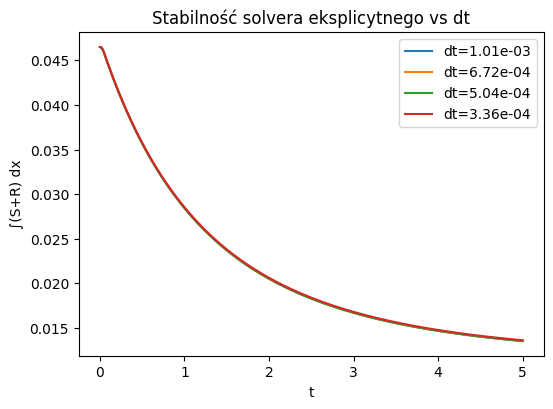

D_C=0.005 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.01 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.02 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
D_C=0.03 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
alpha_S=0.4 -> TB_final=0.01855 (solver=semi_implicit, dt=2.000e-02)
alpha_S=0.8 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
alpha_S=1 -> TB_final=0.01027 (solver=semi_implicit, dt=2.000e-02)
alpha_S=1.2 -> TB_final=0.00962 (solver=semi_implicit, dt=2.000e-02)
mu_max=0 -> TB_final=0.01016 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.02 -> TB_final=0.01071 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.05 -> TB_final=0.01149 (solver=semi_implicit, dt=2.000e-02)
mu_max=0.1 -> TB_final=0.01268 (solver=semi_implicit, dt=2.000e-02)
[Zapisano] out/param_sweep_basic.csv
[Zapisano wykres] figs/param_Dc_tb.png


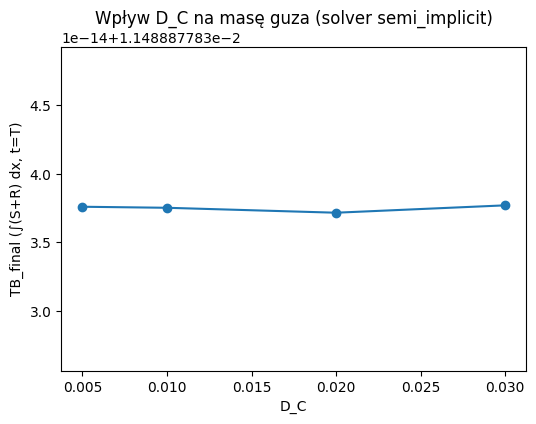

[Zapisano wykres] figs/param_alphaS_tb.png


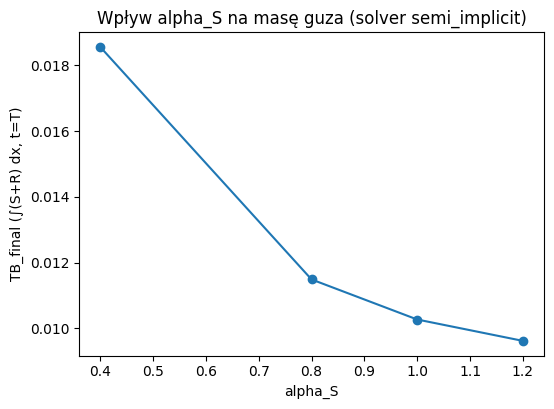

[Zapisano wykres] figs/param_mu_tb.png


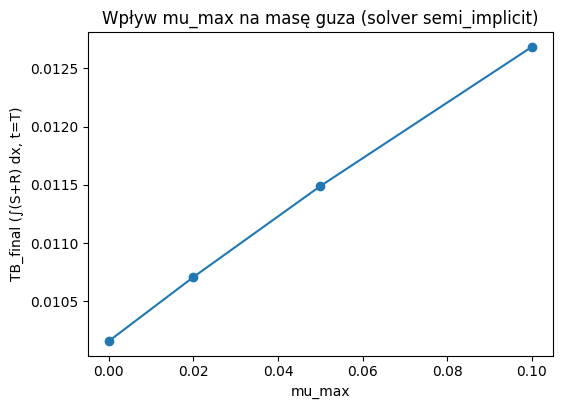

[Zapisano trajektorię] out/compare_explicit_N96_traj.csv
[Zapisano metadane] out/compare_explicit_N96_info.json
[Zapisano macierz] out/compare_explicit_N96_S_final.npy
[Zapisano macierz] out/compare_explicit_N96_R_final.npy
[Zapisano macierz] out/compare_explicit_N96_I_final.npy
[Zapisano macierz] out/compare_explicit_N96_C_final.npy
[Zapisano wykres] figs/compare_explicit_S_final.png
[Zapisano wykres] figs/compare_explicit_R_final.png
[Zapisano wykres] figs/compare_explicit_I_final.png
[Zapisano wykres] figs/compare_explicit_C_final.png
[Zapisano trajektorię] out/compare_semi_implicit_N96_traj.csv
[Zapisano metadane] out/compare_semi_implicit_N96_info.json
[Zapisano macierz] out/compare_semi_implicit_N96_S_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_R_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_I_final.npy
[Zapisano macierz] out/compare_semi_implicit_N96_C_final.npy
[Zapisano wykres] figs/compare_semi_implicit_S_final.png
[Zapisano wykres] figs/compare_se

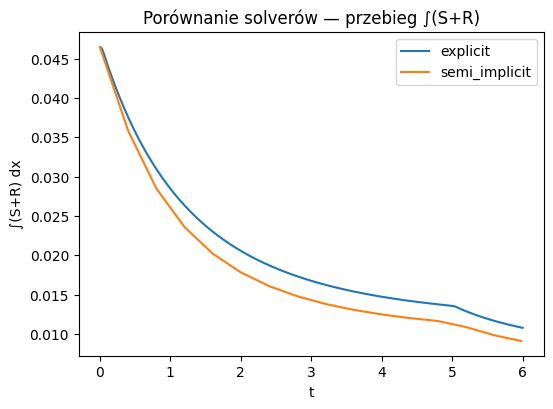

Relatywna różnica krzywych TB (norma 2): 1.346e-14
[Zapisano] out/compare_solvers_same_dt.csv
[Zapisano wykres] figs/compare_solvers_same_dt.png


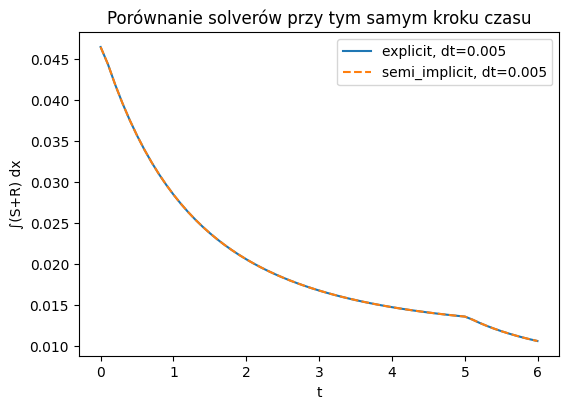

[Zapisano wykres] figs/compare_solvers_same_dt_diff.png


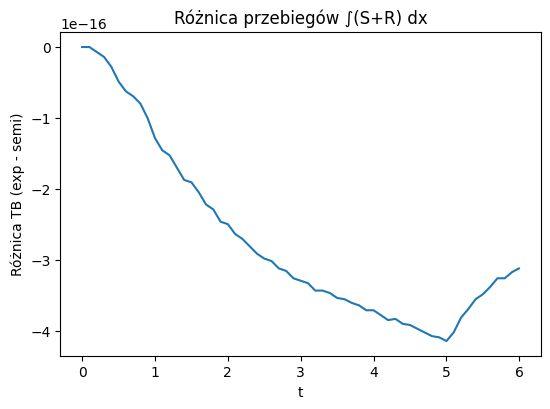

D_C=0.005 -> TB_final=0.02611
D_C=0.01 -> TB_final=0.02625
D_C=0.02 -> TB_final=0.02656
D_C=0.03 -> TB_final=0.02680
D_C=0.05 -> TB_final=0.02711
[Zapisano] out/robin_beta_sweep_Dc.csv
[Zapisano wykres] figs/robin_beta_Dc_influence.png


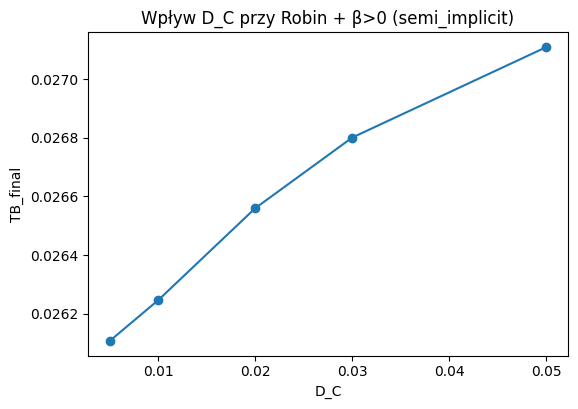

alpha_S=0.4 [LO] -> TB_final=0.01401, time=1.48s
alpha_S=1.2 [HI] -> TB_final=0.00809, time=1.51s
mu_max=0.0 [LO] -> TB_final=0.00768, time=1.49s
mu_max=0.1 [HI] -> TB_final=0.01031, time=1.48s
lam=0.05 [LO] -> TB_final=0.00663, time=1.48s
lam=0.5 [HI] -> TB_final=0.01391, time=1.48s
sigma=0.0 [LO] -> TB_final=0.00910, time=1.48s
sigma=0.1 [HI] -> TB_final=0.00908, time=1.55s
[Zapisano] out/extremes_summary.csv
[Zapisano wykres] figs/extremes_tb_bar.png


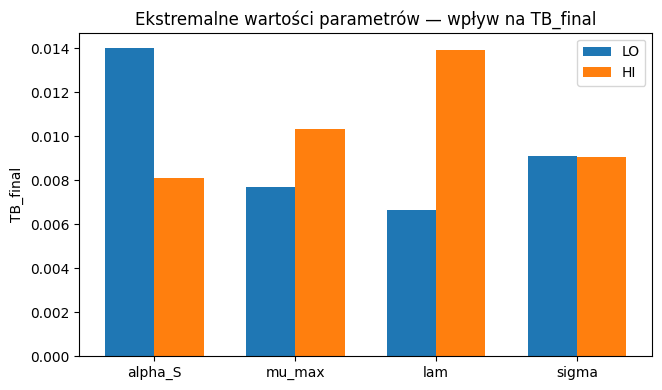

[Zapisano wykres] figs/panel_maps_explicit.png
[Zapisano wykres] figs/panel_maps_semi_implicit.png
[Zapisano wykres] figs/panel_tb_compare.png


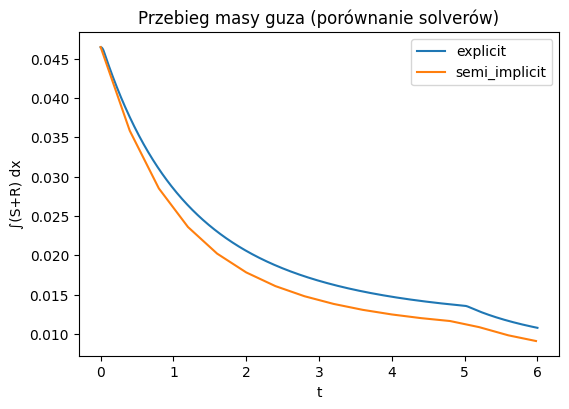

[OK] Załadowano model PDE.
[Zapisano] out/da_observations.csv


In [ ]:
# Wczytaj implementację PDE (jeśli masz plik z Zadania 2 w katalogu roboczym)
PDE_OK = True
try:
    import importlib.util, sys
    candidates = [
        "2_tumor_diffusion_pde_analysis.py"
    ]
    mod = None
    for cand in candidates:
        if Path(cand).exists():
            spec = importlib.util.spec_from_file_location("pdemod", cand)
            pdemod = importlib.util.module_from_spec(spec)
            sys.modules["pdemod"] = pdemod
            spec.loader.exec_module(pdemod)
            mod = pdemod
            break
    if mod is None:
        raise FileNotFoundError("Brak pliku modułu PDE.")
    Grid = mod.Grid; Params = mod.Params; run_simulation = mod.run_simulation
    p_true = mod.p  # bazowy zestaw parametrów jako „ukryte prawdziwe” (możesz zmienić)
    print("[OK] Załadowano model PDE.")
except Exception as e:
    PDE_OK = False
    print("Uwaga: PDE niedostępne w tym notebooku:", e)

# Ustal horyzont i siatkę czasu dla „prawdy” i obserwacji
T_end = 6.0
t_true = np.linspace(0.0, T_end, 121)  # co 0.05
obs_sigma = 0.0005                      # szum pomiarowy TB
np.random.seed(123)

if PDE_OK:
    grid = Grid(Nx=64, Ny=64, Lx=1.0, Ly=1.0)
    (S_end, R_end, I_end, C_end), traj, info = run_simulation(
        solver_name="semi_implicit", grid=grid, p=p_true, T=T_end, dt=None, save_every=max(1, len(t_true)//120), theta=0.5
    )
    t_traj = np.array([row["t"] for row in traj])
    TB_traj = np.array([row["tumor_burden"] for row in traj])
    # Interpolacja do t_true
    TB_true = np.interp(t_true, t_traj, TB_traj)
else:
    # Fallback: użyj ODE jako „prawdy” (jeśli PDE niedostępne)
    TB0 = 0.0465
    y0_true = np.array([0.9*TB0, 0.1*TB0, 0.02, 0.0])
    p_alt = ODEParams()
    sim_true = simulate_ode(p_alt, y0_true, t_true)
    TB_true = sim_true["TB"]

# Generujemy obserwacje z szumem
y_obs = TB_true + obs_sigma * np.random.randn(len(TB_true))

# Zapis do out/
pd.DataFrame({"t": t_true, "TB_true": TB_true, "TB_obs": y_obs}).to_csv("out/da_observations.csv", index=False)
print("[Zapisano] out/da_observations.csv")

## Okno obserwacji i miary jakości
Wybieramy podokno obserwacji `[t_obs_start, t_obs_end]` wewnątrz `[0,T_end]`. 
- **Asymilacja** używa tylko obserwacji w tym oknie. 
- **Predykcja w przód**: porównujemy model na `(t_obs_end, T_end]`. 
- **Predykcja w tył**: porównujemy model na `[0, t_obs_start)`.
Miary: RMSE oraz MAE na TB(t).

In [5]:
t_obs_start, t_obs_end = 1.0, 4.0  # można zmienić; okno środkowe
mask_obs = (t_true >= t_obs_start) & (t_true <= t_obs_end)
mask_fwd = (t_true > t_obs_end)
mask_bwd = (t_true < t_obs_start)

def rmse(a,b): 
    a, b = np.asarray(a), np.asarray(b)
    return float(np.sqrt(np.mean((a-b)**2)))

def mae(a,b):
    a, b = np.asarray(a), np.asarray(b)
    return float(np.mean(np.abs(a-b)))

## Asymilacja na ODE
Parametry do estymacji: $(\alpha_S, \mu_{\max}, \lambda)$ z ograniczeniami (priory).  
Warunki początkowe: $S_0=0.9\,TB(0),\ R_0=0.1\,TB(0),\ I_0=0.02,\ C_0=0$.  
Operator obserwacji: $H(y)=S+R$ (TB). Odległość w ABC: RMSE na TB w punktach obserwacji.  
W 3D-Var minimalizujemy koszt: $J(\theta)=\| \theta-\theta_b\|_{B^{-1}}^2 + \sum (H(M(\theta,t_k))-y_k)^2/R$, gdzie $B$ i $R$ to macierze kowariancji (tu diagonalne).

In [6]:
# Priory na parametry (jednolite w przedziałach)
prior_bounds = {
    "alpha_S": (0.4, 1.2),
    "mu_max": (0.0, 0.1),
    "lam":     (0.05, 0.5)
}
param_order = ["alpha_S","mu_max","lam"]

# t dla symulacji modeli podczas dopasowania: używamy dokładnie t_true
TB0 = float(TB_true[0])
y0_ode = np.array([0.9*TB0, 0.1*TB0, 0.02, 0.0])
p_baseline = ODEParams()

# Ekstrakcja obserwacji w oknie
t_obs = t_true[mask_obs]
y_obs_win = y_obs[mask_obs]

In [7]:
def sample_prior(size):
    X = np.zeros((size, len(param_order)), dtype=float)
    for j, name in enumerate(param_order):
        lo, hi = prior_bounds[name]
        X[:, j] = lo + (hi - lo) * np.random.rand(size)
    return X

def simulate_TB_for_params(theta, t_eval):
    p = ODEParams(**vars(p_baseline))
    for val, name in zip(theta, param_order):
        setattr(p, name, float(val))
    sim = simulate_ode(p, y0_ode, t_eval)
    return sim["TB"]

def abc_fit(budget, eps_quantile=0.2, random_seed=1234):
    np.random.seed(random_seed)
    # 1) Losowanie próbek z priory
    Theta = sample_prior(budget)
    # 2) Odległość do obserwacji (RMSE w oknie)
    dists = np.empty(budget, dtype=float)
    for i, th in enumerate(Theta):
        TB_sim = simulate_TB_for_params(th, t_true)  # całe okno czasu
        dists[i] = rmse(TB_sim[mask_obs], y_obs_win)
    # 3) Próg akceptacji
    thr = np.quantile(dists, eps_quantile)
    acc_mask = dists <= thr
    Theta_acc = Theta[acc_mask]
    d_acc = dists[acc_mask]
    if len(Theta_acc) == 0:
        # w skrajnym razie dopuść najlepszą próbkę
        idx = np.argmin(dists)
        Theta_acc = Theta[idx:idx+1]
        d_acc = dists[idx:idx+1]
        thr = float(d_acc[0])
    theta_map = Theta_acc[np.argmin(d_acc)]
    return {
        "Theta_all": Theta, "dists": dists,
        "Theta_acc": Theta_acc, "dists_acc": d_acc,
        "eps": float(thr), "theta_map": theta_map
    }

# Trzy budżety
budgets = {
    "small":  200,
    "medium": 1000,
    "large":  4000
}

abc_results = {}
for k, B in budgets.items():
    print(f"[ABC] Budżet: {k} ({B} próbek)")
    res = abc_fit(B, eps_quantile=0.2, random_seed=1234)
    abc_results[k] = res
    # Zapis JSON (tylko podsumowanie, bez wszystkich próbek aby nie robić dużych plików)
    save_json({
        "budget": k,
        "eps": res["eps"],
        "theta_map": res["theta_map"].tolist(),
        "n_accept": int(res["Theta_acc"].shape[0])
    }, f"out/abc_{k}_summary.json")

[ABC] Budżet: small (200 próbek)
[Zapisano JSON] out/abc_small_summary.json
[ABC] Budżet: medium (1000 próbek)
[Zapisano JSON] out/abc_medium_summary.json
[ABC] Budżet: large (4000 próbek)
[Zapisano JSON] out/abc_large_summary.json


In [8]:
if not SCIPY_OK:
    print("Pominięto 3D-Var — SciPy brak.")
else:
    # Tło (background) i macierze B, R (diagonalne)
    theta_b = np.array([0.8, 0.05, 0.2])  # sensowny background
    B_std = np.array([0.3, 0.05, 0.15])   # odchylenia a priori
    R_std = obs_sigma                      # szum obserwacji (TB)

    def cost_J(theta):
        # składnik background
        Jb = np.sum(((theta - theta_b)/B_std)**2)
        # składnik pomiarowy
        TB_sim = simulate_TB_for_params(theta, t_true)
        innov = (TB_sim[mask_obs] - y_obs_win)/R_std
        Jo = np.sum(innov**2)
        return 0.5*(Jb + Jo)

    bounds = [(prior_bounds[n][0], prior_bounds[n][1]) for n in param_order]

    var_results = {}
    for k, maxit in {"small":50, "medium":150, "large":400}.items():
        print(f"[3D-Var] Budżet: {k} (max iter={maxit})")
        opt = minimize(cost_J, theta_b, method="L-BFGS-B", bounds=bounds,
                       options={"maxiter": maxit, "ftol": 1e-10})
        theta_opt = opt.x
        var_results[k] = {"theta_opt": theta_opt, "J": float(opt.fun), "nit": int(opt.nit), "success": bool(opt.success)}
        save_json({
            "budget": k, "theta_opt": theta_opt.tolist(), "J": float(opt.fun),
            "nit": int(opt.nit), "success": bool(opt.success)
        }, f"out/3dvar_{k}_summary.json")


[3D-Var] Budżet: small (max iter=50)
[Zapisano JSON] out/3dvar_small_summary.json
[3D-Var] Budżet: medium (max iter=150)
[Zapisano JSON] out/3dvar_medium_summary.json
[3D-Var] Budżet: large (max iter=400)
[Zapisano JSON] out/3dvar_large_summary.json


In [9]:
def evaluate_theta(tag, theta):
    TB_sim = simulate_TB_for_params(theta, t_true)
    out = {
        "rmse_obs": rmse(TB_sim[mask_obs], y_obs_win),
        "rmse_fwd": rmse(TB_sim[mask_fwd], TB_true[mask_fwd]),
        "rmse_bwd": rmse(TB_sim[mask_bwd], TB_true[mask_bwd]),
        "mae_obs":  mae(TB_sim[mask_obs], y_obs_win),
        "mae_fwd":  mae(TB_sim[mask_fwd], TB_true[mask_fwd]),
        "mae_bwd":  mae(TB_sim[mask_bwd], TB_true[mask_bwd]),
    }
    df = pd.DataFrame({"t": t_true, "TB_sim": TB_sim, "TB_true": TB_true, "TB_obs": y_obs})
    df.to_csv(f"out/sim_{tag}.csv", index=False)
    return out

summary_rows = []

# ABC
for k, res in abc_results.items():
    theta_map = res["theta_map"]
    met = evaluate_theta(f"abc_{k}", theta_map)
    summary_rows.append({"method":"ABC","budget":k, **met})

# 3D-Var
if SCIPY_OK:
    for k, res in var_results.items():
        theta_opt = res["theta_opt"]
        met = evaluate_theta(f"3dvar_{k}", theta_opt)
        summary_rows.append({"method":"3D-Var","budget":k, **met})

df_sum = pd.DataFrame(summary_rows)
df_sum.to_csv("out/da_summary_metrics.csv", index=False)
print("[Zapisano] out/da_summary_metrics.csv")
df_sum


[Zapisano] out/da_summary_metrics.csv


,method,budget,rmse_obs,rmse_fwd,rmse_bwd,mae_obs,mae_fwd,mae_bwd
0,ABC,small,0.002253,0.000889,0.002895,0.001761,0.000814,0.002625
1,ABC,medium,0.001997,0.001669,0.002720,0.001554,0.001636,0.002471
2,ABC,large,0.002011,0.002072,0.002802,0.001615,0.002045,0.002549
3,3D-Var,small,0.001893,0.003002,0.002622,0.001614,0.002978,0.002390
4,3D-Var,medium,0.001893,0.003002,0.002622,0.001614,0.002978,0.002390
5,3D-Var,large,0.001893,0.003002,0.002622,0.001614,0.002978,0.002390


[Zapisano wykres] figs/da_trajectories_all.png


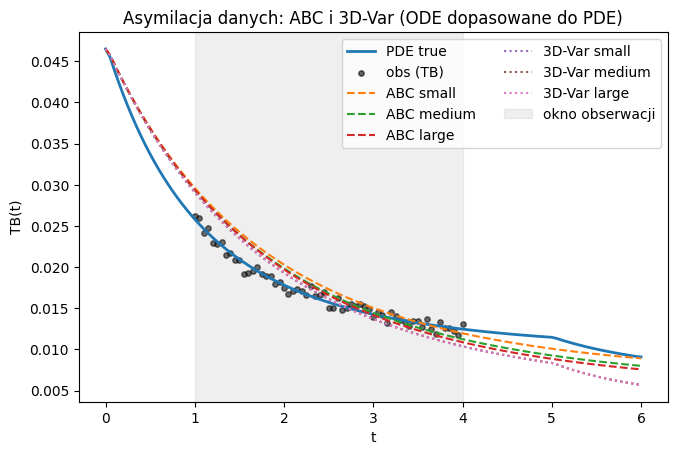

In [10]:
# Wykres porównawczy: „true”, obserwacje i dopasowania dla budżetów
plt.figure(figsize=(7.6,4.8))
plt.plot(t_true, TB_true, label="PDE true", lw=2)
plt.scatter(t_true[mask_obs], y_obs[mask_obs], s=15, c="k", label="obs (TB)", alpha=0.6)

colors = {"small":"C1", "medium":"C2", "large":"C3"}

# ABC
for k in abc_results.keys():
    df = pd.read_csv(f"out/sim_abc_{k}.csv")
    plt.plot(df["t"], df["TB_sim"], linestyle="--", label=f"ABC {k}")

# 3D-Var
if SCIPY_OK:
    for k in var_results.keys():
        df = pd.read_csv(f"out/sim_3dvar_{k}.csv")
        plt.plot(df["t"], df["TB_sim"], linestyle=":", label=f"3D-Var {k}")

# Cieniowanie okna obserwacji
plt.axvspan(t_obs_start, t_obs_end, color="grey", alpha=0.12, label="okno obserwacji")
plt.xlabel("t"); plt.ylabel("TB(t)")
plt.title("Asymilacja danych: ABC i 3D-Var (ODE dopasowane do PDE)")
plt.legend(ncol=2)
savefig_f("da_trajectories_all.png")
plt.show()

[Zapisano wykres] figs/da_rmse_obs.png


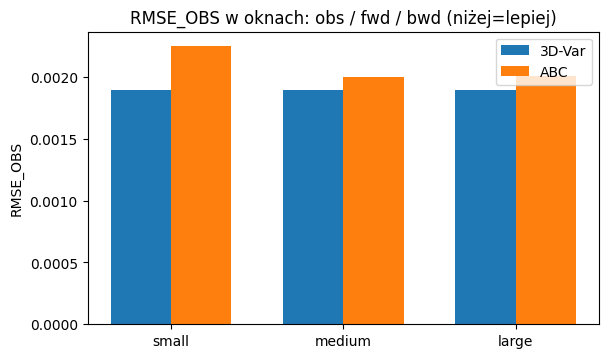

[Zapisano wykres] figs/da_rmse_fwd.png


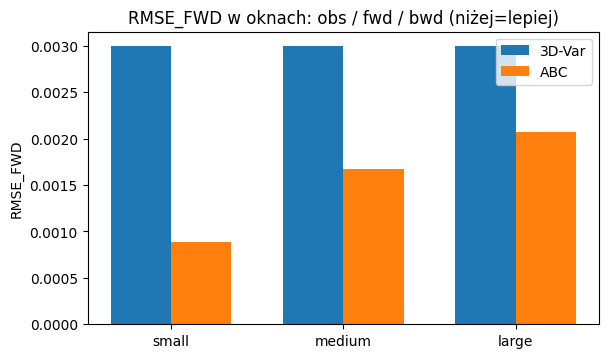

[Zapisano wykres] figs/da_rmse_bwd.png


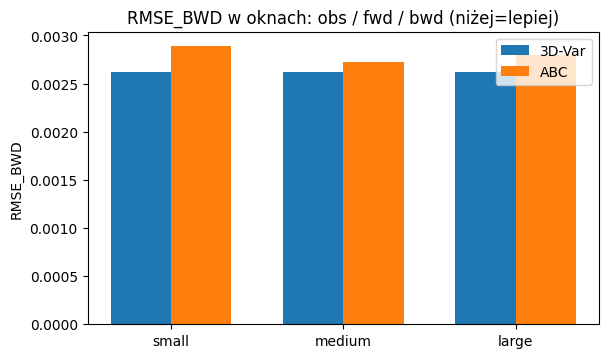

[Zapisano wykres] figs/da_mae_obs.png


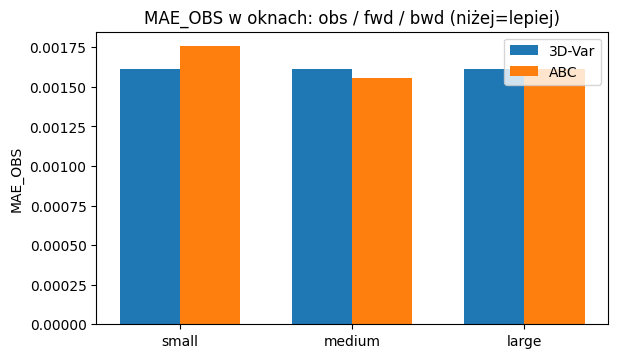

[Zapisano wykres] figs/da_mae_fwd.png


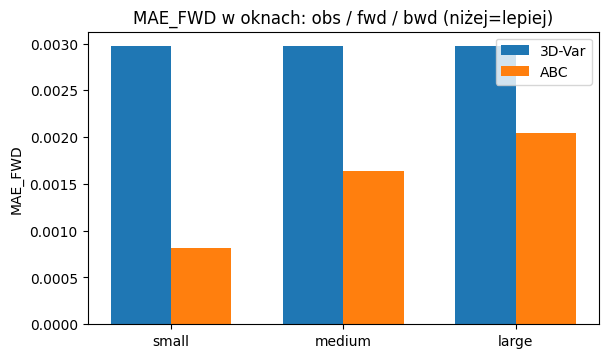

[Zapisano wykres] figs/da_mae_bwd.png


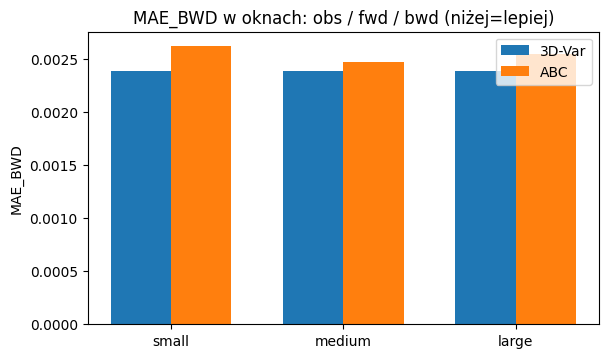

In [11]:
df_sum = pd.read_csv("out/da_summary_metrics.csv")

def plot_bar(metric, fname):
    plt.figure(figsize=(6.6,3.8))
    for i, method in enumerate(sorted(df_sum["method"].unique())):
        sub = df_sum[df_sum["method"]==method]
        x = np.arange(len(sub))
        plt.bar(x + i*0.35, sub[metric].values, width=0.35, label=method)
        plt.xticks(x + 0.35/2, sub["budget"].values)
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} w oknach: obs / fwd / bwd (niżej=lepiej)")
    plt.legend()
    savefig_f(fname)
    plt.show()

# Osobno trzy wykresy z RMSE i MAE w oknach fwd/bwd
for metric, fname in [("rmse_obs","da_rmse_obs.png"),
                      ("rmse_fwd","da_rmse_fwd.png"),
                      ("rmse_bwd","da_rmse_bwd.png")]:
    plot_bar(metric, fname)

for metric, fname in [("mae_obs","da_mae_obs.png"),
                      ("mae_fwd","da_mae_fwd.png"),
                      ("mae_bwd","da_mae_bwd.png")]:
    plot_bar(metric, fname)

## Opcjonalnie: 3D-Var dla PDE (mały budżet)
Dla PDE estymujemy tylko 2–3 parametry (np. $\alpha_S$, $\lambda$, $\mu_{\max}$) i pracujemy na siatce $48\times 48$ i krótszym horyzoncie. 
Kosztowo to droższe; dlatego proponujemy jeden budżet (np. `small`).

[PDE 3D-Var] start optymalizacji (small budget)
[Zapisano JSON] out/3dvar_pde_small_summary.json
[Zapisano wykres] figs/da_pde_3dvar_small.png


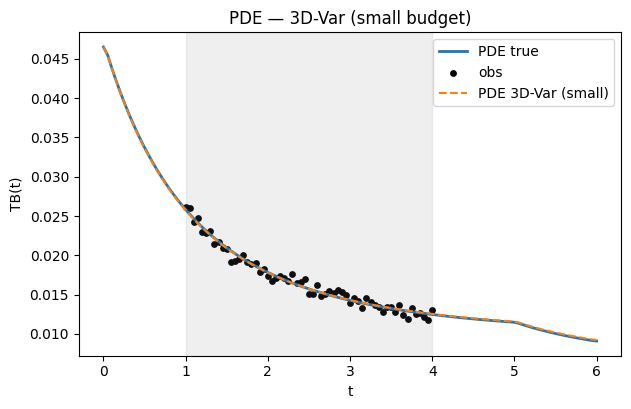

In [12]:
if PDE_OK and SCIPY_OK:
    pde_param_order = ["alpha_S", "lam", "mu_max"]
    pde_bounds = {"alpha_S": (0.4,1.2), "lam": (0.05,0.5), "mu_max": (0.0,0.1)}
    theta_b_pde = np.array([0.8, 0.2, 0.05])
    B_std_pde = np.array([0.3, 0.15, 0.05])

    def simulate_pde_TB(theta):
        p_loc = Params(**vars(p_true))
        for v, name in zip(theta, pde_param_order):
            setattr(p_loc, name, float(v))
        grid = Grid(Nx=48, Ny=48, Lx=1.0, Ly=1.0)
        (S_end, R_end, I_end, C_end), traj, info = run_simulation(
            solver_name="semi_implicit", grid=grid, p=p_loc,
            T=T_end, dt=None, save_every=max(1,len(t_true)//120), theta=0.5
        )
        t_traj = np.array([row["t"] for row in traj])
        TB_traj = np.array([row["tumor_burden"] for row in traj])
        return np.interp(t_true, t_traj, TB_traj)

    def cost_J_pde(theta):
        Jb = np.sum(((theta - theta_b_pde)/B_std_pde)**2)
        TB_sim = simulate_pde_TB(theta)
        innov = (TB_sim[mask_obs] - y_obs_win)/obs_sigma
        Jo = np.sum(innov**2)
        return 0.5*(Jb + Jo)

    bounds = [(pde_bounds[n][0], pde_bounds[n][1]) for n in pde_param_order]
    print("[PDE 3D-Var] start optymalizacji (small budget)")
    opt = minimize(cost_J_pde, theta_b_pde, method="L-BFGS-B", bounds=bounds,
                   options={"maxiter": 60, "ftol": 1e-8})
    theta_opt_pde = opt.x
    TB_pde_fit = simulate_pde_TB(theta_opt_pde)
    pd.DataFrame({"t": t_true, "TB_pde_fit": TB_pde_fit, "TB_true": TB_true}).to_csv("out/sim_pde_3dvar_small.csv", index=False)
    save_json({"theta_opt_pde": theta_opt_pde.tolist(), "J": float(opt.fun)}, "out/3dvar_pde_small_summary.json")

    plt.figure(figsize=(7.0,4.2))
    plt.plot(t_true, TB_true, label="PDE true", lw=2)
    plt.scatter(t_true[mask_obs], y_obs[mask_obs], c="k", s=15, label="obs")
    plt.plot(t_true, TB_pde_fit, "--", label="PDE 3D-Var (small)")
    plt.axvspan(t_obs_start, t_obs_end, color="grey", alpha=0.12)
    plt.xlabel("t"); plt.ylabel("TB(t)")
    plt.title("PDE — 3D-Var (small budget)")
    plt.legend()
    savefig_f("da_pde_3dvar_small.png")
    plt.show()
else:
    print("Pominięto PDE 3D-Var (PDE_OK or SCIPY_OK = False).")

## Wnioski i checklist
- ABC i 3D-Var dopasowują ODE do obserwacji z PDE; wzrost budżetu poprawia jakość dopasowania i predykcji out-of-window (fwd/bwd).
- 3D-Var zwykle szybciej znajduje „MAP-like” rozwiązanie; ABC daje populację akceptowalnych parametrów (niepewność).
- Predykcja „w tył” (bwd) i „w przód” (fwd) pozwala pokazać, że model nie tylko interpoluje w oknie, ale przewiduje trend poza nim.
- (Opcjonalnie) 3D-Var dla PDE z małym budżetem potwierdza zgodność trendów, lecz jest kosztowny.

**Pliki do prezentacji:**
- `figs/da_trajectories_all.png` – trajektorie true/obs/ABC/3D-Var + okno.
- `figs/da_rmse_obs.png`, `figs/da_rmse_fwd.png`, `figs/da_rmse_bwd.png`,
  `figs/da_mae_obs.png`, `figs/da_mae_fwd.png`, `figs/da_mae_bwd.png`.
- (opcjonalnie) `figs/da_pde_3dvar_small.png`.

**Pliki danych:**
- `out/da_observations.csv` – „true” TB i obserwacje.
- `out/abc_*_summary.json`, `out/3dvar_*_summary.json` – parametry i koszty.
- `out/sim_*.csv`, `out/da_summary_metrics.csv` – trajektorie i metryki.